In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras as keras
from keras import layers as layers
import numpy as np

In [3]:
import os
import cv2
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from math import inf as inf
import numpy as np

In [4]:
from spectral.io import envi as envi
from spectral import imshow

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
#Testing Constants
TESTING = True

#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.7
IMAGE_COUNT = 10

In [7]:
# List for All varieties
VARIETIES = []
for name in os.listdir("./../wheat/data/BULK"):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES.append(name)

In [8]:
#List for all file names in varities
FILES = []
MAX_FILE_NUM = 4
for x in range(1,MAX_FILE_NUM+1):
    FILES.append("B_"+str(x))

In [9]:
def exactPathHDR(variety,file):
    return "D:\mvl\wheat\data\BULK\\"+variety+"\\"+file+".bil.hdr"

def exactPathBIL(variety,file):
    return "D:\mvl\wheat\data\BULK\\"+variety+"\\"+file+".bil"

In [10]:
#List of all images
images = []
images_label = []
for v in VARIETIES:
    for f in FILES:
        try:
            img = envi.open(exactPathHDR(v,f),exactPathBIL(v,f))
            images.append(img)
            images_label.append(v)
        except:
            pass

In [11]:
def getROI(img,band_number):
    img_band = img.read_band(band_number)
    threshold = threshold_otsu(img_band)
    roi=[]
    for x in range(img_band.shape[0]):
        a=[]
        for y in range(img_band.shape[1]):
            if img_band[x][y]>threshold:
                a.append(1)
            else:
                a.append(0)
        roi.append(a)
    return roi

In [12]:
#Returns range for x and y from where we have to crop images
def getRangeXandY(img,band_number):
    img_band = img.read_band(band_number)
    roi = getROI(img,band_number)
    xmin = inf
    xmax = 0
    ymin = inf
    ymax = 0
    for x in range(img_band.shape[0]):
        for y in range(img_band.shape[1]):
            if roi[x][y]==1:
                if x<xmin:
                    xmin=x
                if x>xmax:
                    xmax=x
                if y<ymin:
                    ymin=y
                if y>ymax:
                    ymax=y
    return xmin, xmax, ymin, ymax

In [13]:
def getCroppedImage(img,band_number):
    xmin, xmax, ymin, ymax = getRangeXandY(img,band_number)
    new_img = img[xmin:xmax, ymin:ymax, :]
    return new_img    

In [14]:
def getCroppedROI(img,band_number):
    xmin, xmax, ymin, ymax = getRangeXandY(img,band_number)
    roi = np.array(getROI(img,band_number))
    roi = roi[xmin:xmax, ymin:ymax]
    return roi   

In [15]:
def getUsefulImage(img,band_number):
    crop_img = getCroppedImage(img,band_number)
    crop_roi = getCroppedROI(img,band_number)
    for x in range(crop_img.shape[2]):
        band = crop_img[:,:,x]
        crop_img[:,:,x] = band*crop_roi
    return crop_img

In [16]:
data_augmentation = keras.Sequential([
    layers.RandomCrop(height=40, width=40),
    layers.RandomRotation(factor=(-0.1, 0.1)),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1,0.1)),
])

def getAugumentedImage(img,band_number):
    new_img = getUsefulImage(images[0],band_number)
    augmented_image = data_augmentation(new_img) 
    return augmented_image

def checkAugumentedImage(augmented_image):
    aug_band = augmented_image[:,:,0]
    filled_area_ratio = (np.count_nonzero(aug_band))/(aug_band.shape[0]*aug_band.shape[1])
    if filled_area_ratio > FILLED_AREA_RATIO :
        return True
    else:
        return False

In [2]:
## Split Training, Validation and Test Sets
def SplitTr_Te(HSI, GT, TeRatio, randomState=345):
    Tr, Te, TrC, TeC = train_test_split(HSI, GT, test_size=TeRatio, random_state=randomState, stratify=GT)
    return Tr, Te, TrC, TeC

In [3]:
## Dimensional Reduction Method
def DL_Method(HSI, numComponents = 75):
    RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
    n_batches = 256
    inc_pca = IncrementalPCA(n_components=numComponents)
    for X_batch in np.array_split(RHSI, n_batches):
        inc_pca.partial_fit(X_batch)
    X_ipca = inc_pca.transform(RHSI)
    RHSI = np.reshape(X_ipca, (HSI.shape[0],HSI.shape[1], numComponents))
    return RHSI

In [17]:
dataset = []
dataset_label = []

for index, img in enumerate(images):
    count = 0
    label = images_label[index]
    while count<IMAGE_COUNT:
        aug_img = getAugumentedImage(img,BAND_NUMBER)
        if checkAugumentedImage(aug_img):
            dataset.append(aug_img)
            dataset_label.append(label)
            count+=1  
            
    if TESTING:
        break

DBW 187
DBW 187
DBW 187
DBW 187
DBW 187
DBW 187
DBW 187
DBW 187
DBW 187
DBW 187


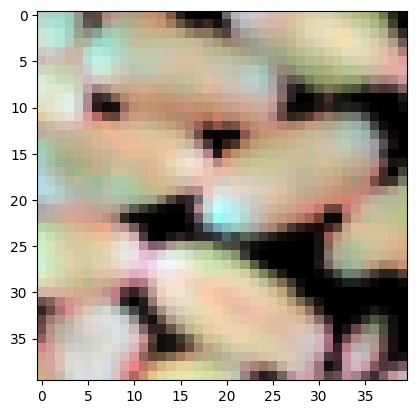

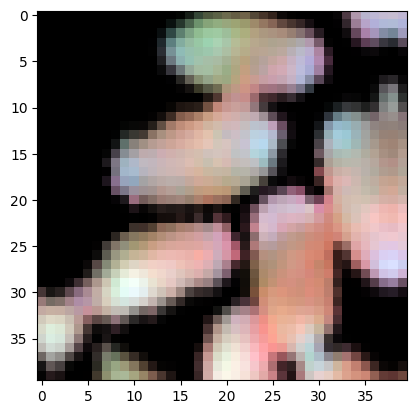

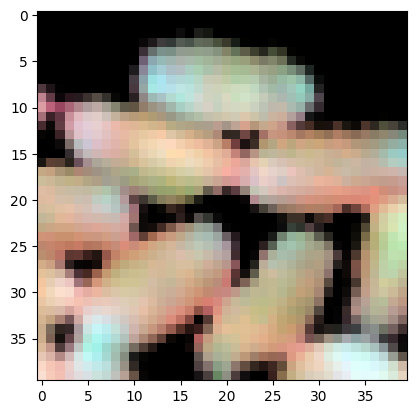

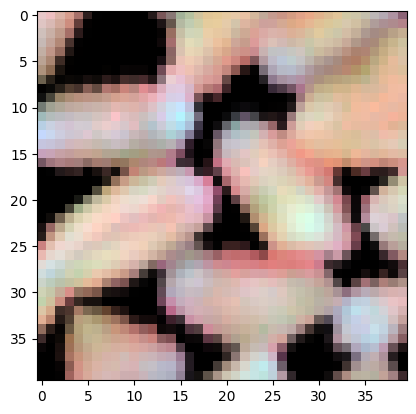

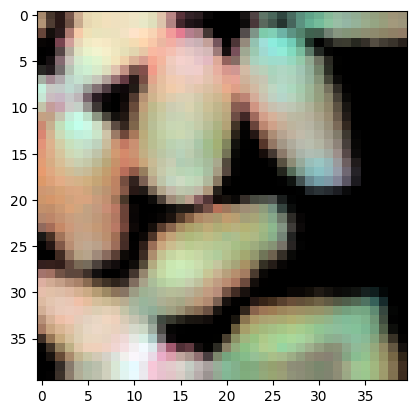

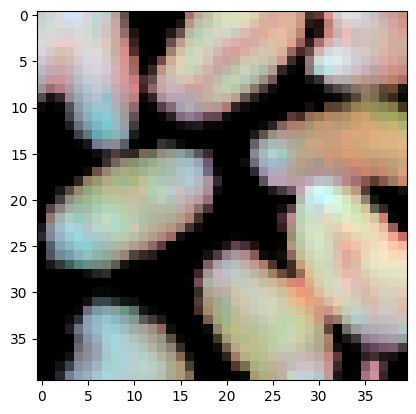

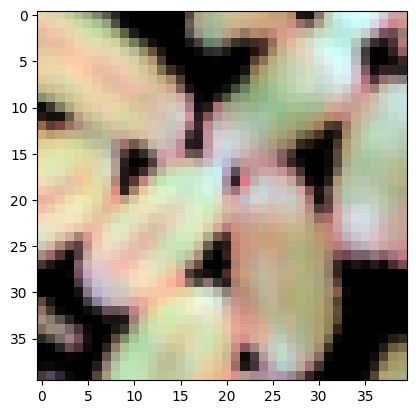

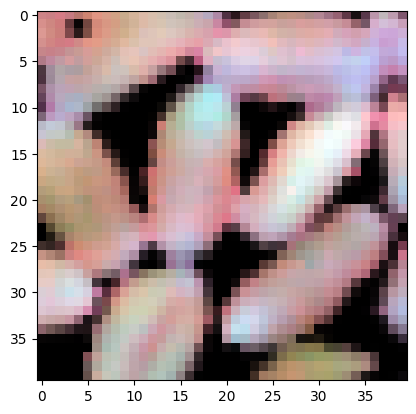

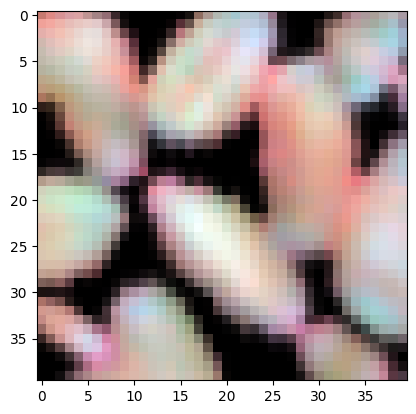

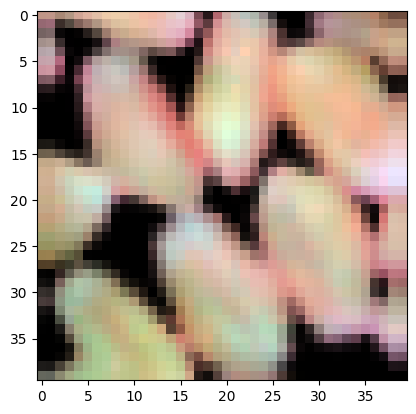

In [18]:
for index,data in enumerate(dataset):
    imshow(data)
    print(dataset_label[index])
    